Loading Women's Data (Analyzing Decisions on Men's Earnings)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_3852/3869981562.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['v005'] / 1000000.0



✅ Success: Data saved to figure_46_eastern_report.json
           Mainly wife  Both  Mainly husband
Location                                    
Rwamagana            6    83              11
Nyagatare            4    61              36
Gatsibo              3    71              27
Kayonza              8    79              13
Kirehe               6    63              31
Ngoma                4    80              16
Bugesera             6    68              26
East                 5    72              23
Rwanda               6    70              24
📊 Plot saved as 'Women_Report_Men_Earnings_Final.png'


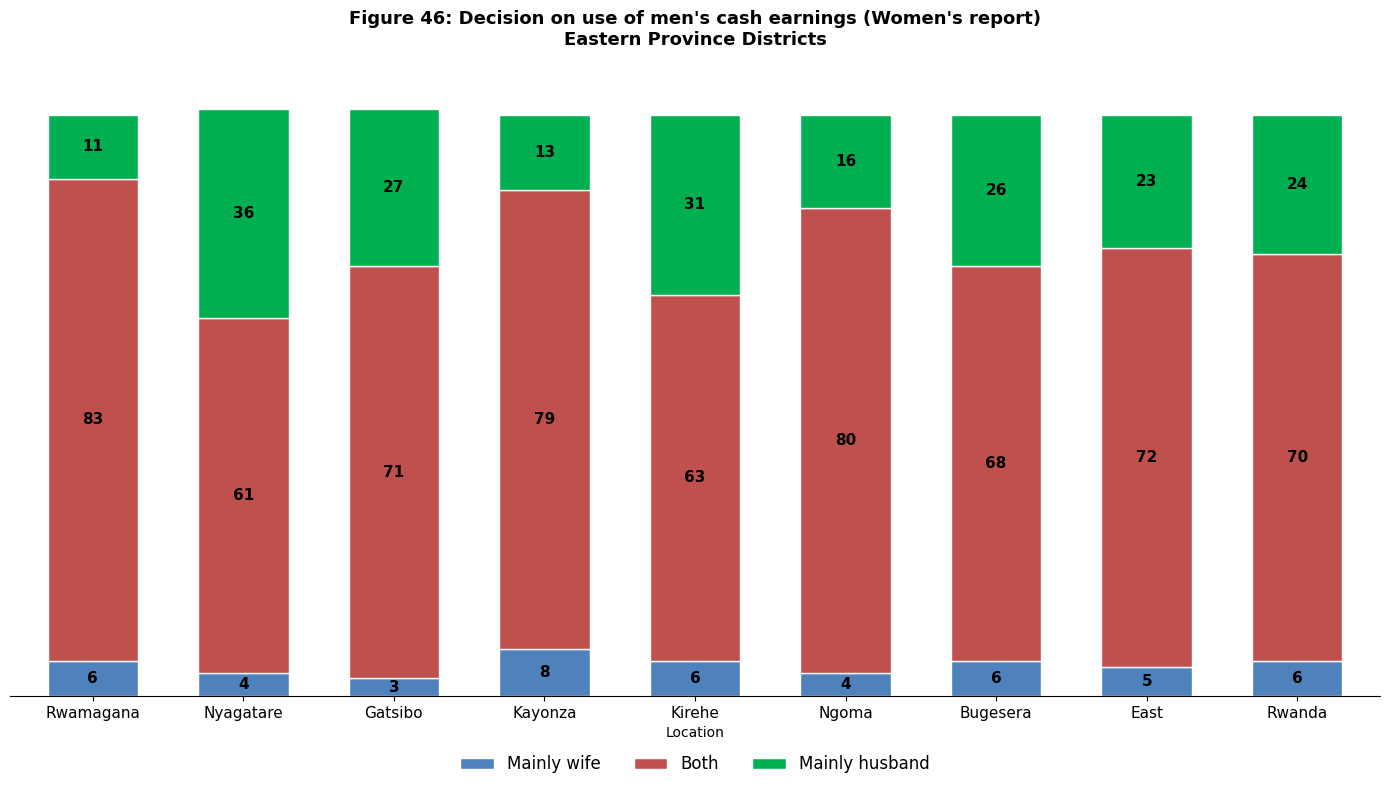

In [1]:
#!/usr/bin/env python3
# dhs_women_report_earnings_ordered.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS & MAPPING
# ------------------------------------------------------------------
FILE_WOMEN = os.path.join("data", "RWIR81FL.DTA")

# Mapping strata codes 47-60 to Eastern Province Districts
EASTERN_MAP = {
    47: "Rwamagana", 48: "Rwamagana",
    49: "Nyagatare", 50: "Nyagatare",
    51: "Gatsibo",   52: "Gatsibo",
    53: "Kayonza",   54: "Kayonza",
    55: "Kirehe",    56: "Kirehe",
    57: "Ngoma",     58: "Ngoma",
    59: "Bugesera",  60: "Bugesera"
}

# The specific requested display order
DISTRICT_ORDER = [
    "Rwamagana", "Nyagatare", "Gatsibo", "Kayonza", 
    "Kirehe", "Ngoma", "Bugesera"
]

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """Rounds 0.5 and up to next integer."""
    return int(math.floor(n + 0.5))

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
def process_figure_46_ordered():
    if not os.path.exists(FILE_WOMEN):
        print(f"❌ Error: {FILE_WOMEN} not found.")
        return
    
    print("Loading Women's Data (Analyzing Decisions on Men's Earnings)...")
    # Load with convert_categoricals=False for raw numbers
    df = pd.read_stata(FILE_WOMEN, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # 1. Weights & Filter (Currently Married 15-49)
    df['w'] = df['v005'] / 1000000.0
    
    # DHS Standard Coding for v743f (Women's report on husband's earnings):
    # 1 = Wife mainly
    # 2 = Jointly (Both)
    # 4 = Husband mainly
    valid_codes = [1, 2, 4]
    df = df[(df['v502'] == 1) & 
            (df['v012'].between(15, 49)) & 
            (df['v743f'].isin(valid_codes))].copy()

    # Indicators
    df['Mainly wife']    = (df['v743f'] == 1).astype(int)
    df['Both']           = (df['v743f'] == 2).astype(int)
    df['Mainly husband'] = (df['v743f'] == 4).astype(int)

    # 2. Aggregation Logic
    df['dist_name'] = df['v023'].map(EASTERN_MAP)
    df_eastern = df[df['v024'] == 5].copy()
    
    results = []
    categories = ['Mainly wife', 'Both', 'Mainly husband']
    
    # Process in the specific requested order
    for name in DISTRICT_ORDER + ["East", "Rwanda"]:
        if name == "Rwanda":
            subset = df
        elif name == "East":
            subset = df_eastern
        else:
            subset = df_eastern[df_eastern['dist_name'] == name]
        
        if subset.empty: continue
            
        row = {'Location': name}
        for cat in categories:
            val = np.average(subset[cat], weights=subset['w']) * 100
            row[cat] = standard_round(val)
        results.append(row)
    
    # Create final DataFrame
    final_df = pd.DataFrame(results).set_index('Location')

    # --------------------------------------------------------------
    # 4. JSON OUTPUT (No Decimals)
    # --------------------------------------------------------------
    json_filename = "figure_46_eastern_report.json"
    final_df.to_json(json_filename, orient='index', indent=4)
    
    print("\n" + "="*60)
    print(f"✅ Success: Data saved to {json_filename}")
    print(final_df)

    # --------------------------------------------------------------
    # 5. PLOTTING
    # --------------------------------------------------------------
    # Colors: Blue (Wife), Red (Both), Green (Husband)
    colors = ["#4F81BD", "#C0504D", "#00B050"] 
    ax = final_df.plot(kind="bar", stacked=True, figsize=(14, 8), color=colors, width=0.6, edgecolor="white")
    
    plt.title("Figure 46: Decision on use of men's cash earnings (Women's report)\nEastern Province Districts", 
              fontsize=13, fontweight="bold", pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    ax.yaxis.set_visible(False)
    for s in ['top', 'right', 'left']: ax.spines[s].set_visible(False)
    
    # Add integer labels inside bar segments
    for c in ax.containers:
        labels = [f"{int(v)}" if v > 0 else "" for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', color='black', fontweight='bold', fontsize=11)

    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=3, frameon=False, fontsize=12)
    plt.tight_layout()
    
    plt.savefig("Women_Report_Men_Earnings_Final.png", dpi=300)
    print("📊 Plot saved as 'Women_Report_Men_Earnings_Final.png'")
    plt.show()

if __name__ == "__main__":
    process_figure_46_ordered()